Summary:
The Cancer Genome Atlas provides high dimensional multi-omic characterizations of tumor resections yet with limited sample sizes, on the order of 100 or less samples for certain tissues-of-origin. Generation of quality synthetic TCGA omic samples can benefit the development of machine learning subtype prediction methods. Traditional methods of generating synthetic data, such as UMAP, can benchmark development of sample generation methods that learn a joint-distribution such as a VAE. Here, TCGA omic data for 995 BRCA samples labeled with one of four subtypes were subset to 20,531 gene-expression features that were then embeded with a VAE into a latent space dimension of four features. The VAE was trained on all four BRCA subtypes simultaneously to generate the feature embedding. The data split used a test set ratio of 0.25. The trained encoder was then used to predict the four latent feauture values for each of the 746 training samples. The average values of 2500 pairwise combinations within each latent feature within each subtype was calcuated to generate a synthetic latent space representation of archetypal samples for each BRCA TCGA subtype. These four latent feature spaces corresponding to each subtype were then decoded back to the 20,531 dimension gene space using the trained decoder component of the VAE. Frequency analysis of selected gene features from these synthetic TCGA data can then leverage the statistical power increase of generative modeling to identify subtype-specific genes of interest.

In [1]:
date = '2022-08-18'
version = 'synth_TCGA'

In [12]:
import glob as glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
import time

In [3]:
# BRCA run, step 1, point to subsetted gexp data, 995 samples by 20,531
gxp_files = sorted(glob.glob('../gexp_files/*.tsv'))
gxp_files[2] # <--- set cancer file n

'../gexp_files/BRCA_gxp.tsv'

In [5]:
# BRCA run, step 2, format each expression row as an image sample, scale, x-frm
for i in [gxp_files[2]]:
    # file  = pd.read_csv(i,         # <--- read cancer file n, comment out for devel reruns
    #                    sep = '\t',
    #                    index_col = 0)
    print('file read, comment off for devel')
    train, test = train_test_split(file)
    
    trn_empty = [] # append model-formatted numpy arrays of gene expression values
    trn_index_key = []
    trn_y_list = []
    
    for j, sample in enumerate(train.index):
        gene_row = list(train.iloc[j,1:])
        base = np.array(gene_row + (
            20736 - len(              # dimension of nearest perfect square   
                gene_row)) * [0],
                        dtype=np.uint8).reshape(144,144,1)
        trn_empty.append(base)
        y = train.iloc[j,0]
        trn_y_list.append(y)
        trn_index_key.append(sample)
    formatted = np.array(trn_empty)
    formatted = formatted/255 # train normalization
    X_train_new = formatted

    tst_empty = []
    tst_index_key = []
    tst_y_list = []
    
    for j, sample in enumerate(test.index):
        gene_row = list(test.iloc[j,1:])
        base = np.array(gene_row + (
            20736 - len(
                gene_row)) * [0],
                        dtype=np.uint8).reshape(144,144,1)
        tst_empty.append(base)
        y = test.iloc[j,0]
        tst_y_list.append(y)
        tst_index_key.append(sample)
    formatted = np.array(tst_empty)
    formatted = formatted/255 # test normalization
    X_test_new = formatted
        
    break  

file read, comment off for devel


In [6]:
X_train_new.shape

(746, 144, 144, 1)

In [7]:
X_test_new.shape

(249, 144, 144, 1)

In [8]:
latent_dim = 4

In [9]:
# Build an image VAE with Keras
# from https://becominghuman.ai/using-variational-autoencoder-vae-to-generate-new-images-14328877e88d
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf; tf.compat.v1.disable_eager_execution()
from keras import backend as K
from keras.layers import Input, Dense, Conv2D, Conv2DTranspose, Flatten, Lambda, Reshape
from keras.models import Model
from keras.losses import binary_crossentropy
# import mnist
np.random.seed(25)
tf.executing_eagerly()

def compute_latent(x):
    batch = K.shape(mu)[0] # mu and sigma defined after encoder is built
    dim = K.int_shape(mu)[1]
    eps = K.random_normal(shape=(batch,dim))
    return mu + K.exp(sigma/2)*eps

def kl_reconstruction_loss(true, pred):
    reconstruction_loss = binary_crossentropy(K.flatten(true), K.flatten(pred)) * img_width * img_height
    kl_loss = 1 + sigma - K.square(mu) - K.exp(sigma) # mu and sigma input to loss function
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    return K.mean(reconstruction_loss + kl_loss)

img_height   = X_train_new.shape[1]
img_width    = X_train_new.shape[2]
num_channels = X_train_new.shape[3]
input_shape =  (img_height, img_width, num_channels)

encoder_input = Input(shape=input_shape)
encoder_conv = Conv2D(filters=8, kernel_size=3, strides=2, 
                padding='same', activation='relu')(encoder_input)
encoder_conv = Conv2D(filters=16, kernel_size=3, strides=2,
                padding='same', activation='relu')(encoder_input) # Overwrite (?)
encoder = Flatten()(encoder_conv)                                 # see model.summary() in slides

mu = Dense(latent_dim)(encoder)     # mu defined
sigma = Dense(latent_dim)(encoder)  # sigma defined
                                                                # 2 args to compute lambda
latent_space = Lambda(compute_latent, output_shape=(latent_dim,))([mu, sigma])
                    
conv_shape = K.int_shape(encoder_conv)
decoder_input = Input(shape=(latent_dim,))
decoder = Dense(conv_shape[1]*conv_shape[2]*conv_shape[3], activation='relu')(decoder_input)
decoder = Reshape((conv_shape[1], conv_shape[2], conv_shape[3]))(decoder)
decoder_conv = Conv2DTranspose(filters=16, kernel_size=3, strides=2, 
                           padding='same', activation='relu')(decoder)
decoder_conv = Conv2DTranspose(filters=8, kernel_size=3, strides=2, 
                           padding='same', activation='relu')(decoder)
decoder_conv =  Conv2DTranspose(filters=num_channels, kernel_size=3, 
                          padding='same', activation='sigmoid')(decoder_conv)
encoder = Model(encoder_input, latent_space)
decoder = Model(decoder_input, decoder_conv)
vae = Model(encoder_input, decoder(encoder(encoder_input)))
vae.compile(optimizer='adam', loss=kl_reconstruction_loss)  # blank model set for (pre)training

In [10]:
epochs = 32 # Number of forward / back pass cycles to set model params with training

Train on 746 samples, validate on 249 samples
Epoch 1/32


2022-08-18 13:39:07.167709: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-18 13:39:07.193164: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled


736/746 [============================>.] - ETA: 0s - loss: 13282.1316

/Users/karlberb/opt/anaconda3/lib/python3.9/site-packages/keras/engine/training_v1.py:2045: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


746/746 [==============================] - 3s 5ms/sample - loss: 13268.4289 - val_loss: 12123.1658
Epoch 2/32
746/746 [==============================] - 3s 4ms/sample - loss: 11746.8617 - val_loss: 11344.2825
Epoch 3/32
746/746 [==============================] - 3s 4ms/sample - loss: 11091.0538 - val_loss: 10834.0824
Epoch 4/32
746/746 [==============================] - 3s 4ms/sample - loss: 10691.5880 - val_loss: 10549.6990
Epoch 5/32
746/746 [==============================] - 3s 5ms/sample - loss: 10474.7792 - val_loss: 10394.2416
Epoch 6/32
746/746 [==============================] - 4s 5ms/sample - loss: 10350.6333 - val_loss: 10300.0038
Epoch 7/32
746/746 [==============================] - 4s 5ms/sample - loss: 10271.7490 - val_loss: 10236.7187
Epoch 8/32
746/746 [==============================] - 4s 5ms/sample - loss: 10219.6292 - val_loss: 10193.7691
Epoch 9/32
746/746 [==============================] - 3s 5ms/sample - loss: 10181.8030 - val_loss: 10161.8202
Epoch 10/32
746/746 [

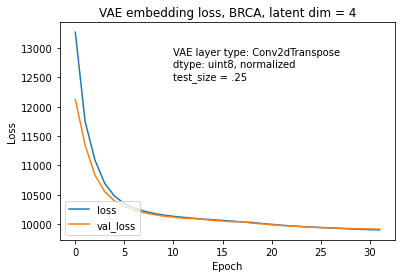

In [11]:
# TCGA VAE training function
history = vae.fit(x=X_train_new, y=X_train_new, epochs=epochs,
                                                  # Here is where the validation data goes
                  batch_size=32, validation_data=(X_test_new, X_test_new))

# Separate plotting from training here            <------- plot only devel break point
plt.plot(history.history['loss'],label="loss")
plt.plot(history.history['val_loss'],label="val_loss")
plt.title('VAE embedding loss, '+
          file.index.name+', latent dim = '+str(latent_dim))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.annotate('VAE layer type: Conv2dTranspose\n'\
                'dtype: uint8, normalized\ntest_size = .25',
            xy=(.4, .8), xycoords='figure fraction',
            horizontalalignment='left', verticalalignment='top',
            # fontsize=20
            )

plt.legend(loc="lower left")
# plt.savefig('dir_n/cohort_n'+str(epochs)+'_epochs_2022-08-date_version.png')
plt.savefig('TCGA_VAE_out/'+
            file.index.name+'_'+
            str(epochs)+'_epochs_'+
            str(latent_dim)+'_latent_dim_'+
            date+'_'+version+'.png')

In [14]:
# Generate and prep latent feature space for subtype-specfic latent feature generation
encoded = encoder.predict(X_train_new)
encDF = pd.DataFrame(encoded)
encDF.insert(0, 'Labels', trn_y_list) # Adding back labls to subset on subtype

In [17]:
sub_n.columns[1:] 

Index([0, 1, 2, 3], dtype='object')

In [23]:
col

0      3.897506
2      5.087799
3      5.709345
4      3.817804
7      3.722259
         ...   
738    6.795300
742    6.748266
743    3.437369
744    4.897128
745    3.538478
Name: 0, Length: 401, dtype: float32

In [24]:
col.index # skipping, index from befor train / test split is preserved

Int64Index([  0,   2,   3,   4,   7,   9,  10,  12,  13,  14,
            ...
            730, 731, 732, 733, 734, 738, 742, 743, 744, 745],
           dtype='int64', length=401)

In [26]:
import random

In [30]:
col.index[1]

2

In [34]:
rdx = random.sample(list(col.index), 1)

In [35]:
rdx

[556]

In [126]:
(random_samples_per_latent_feature*
random_pairs_per_samples)

2500

In [137]:
# Take average of random latent feature pairs to generate synthetic samples
random_samples_per_latent_feature = 50
random_pairs_per_samples = 50
for sb_typ in sorted(encDF.Labels.unique()):
    # break
    print(sb_typ)
    sub_n = encDF[encDF.Labels == sb_typ] # subset on a subtype
    
    sub_start = time.time()
    
    synth_TCGA_latent_sub_n = {} # replace with numpy array to directly poplulate with synth samples (?)
    
    for i in sub_n.columns[1:]: # Table of latent feature values for subtype_n, want exhaustive iteration
        print('starting column ', i)
        
        col = sub_n.loc[:,i]

        synthetic_latent_feature_vals = [] # want 5k or so
        
        col_start = time.time()
        # for j, ndx in enumerate(col.index): # sample loop, replace with random sampling
        for j in list(range(0, random_samples_per_latent_feature)):
            rdx = random.sample(list(col.index), 1)
             # break # Break stepping through each sample's latent feature value within this column
               
            # val = col[ndx] # Take a value from this latent feature column
            # col_not = col.drop(ndx)
            val = col[rdx]   
            col_not = col.drop(rdx)
                      
            pair_val_list = [] # all pairs for the 'val' latent feature for this sample
            # for ndx_not in col_not.index: # Observation: taking the difference of vals seems to tighten the joint dist
            for k in list(range(0,random_pairs_per_samples)):
                rdx_not = random.sample(list(col_not.index), 1)
                      
                # val_not = col_not[ndx_not]
                val_not = col_not[rdx_not]      
                      
                # print(val, val_not)
                new_val = (val.values + val_not.values) / 2 # Generate a synthetic feature value
                pair_val_list.append(new_val[0]) # synthetic feature values for this one latent feature in this one column

                # break
            synthetic_latent_feature_vals = synthetic_latent_feature_vals + pair_val_list
        
        col_end = time.time() - col_start
        print('column run time: ', col_end)
        print(' ')
        # break # Break column loop
        
        synth_TCGA_latent_sub_n[str(i)+'_latent'] = synthetic_latent_feature_vals
    
    print('output dictionary built for this subtype')
    # break # break subtype loop
    
    synth_TCGA_latent_sub_nDF = pd.DataFrame(synth_TCGA_latent_sub_n)
    
    sub_end = time.time() - sub_start
    
    synth_TCGA = decoder.predict(np.array(synth_TCGA_latent_sub_nDF))
    print((random_samples_per_latent_feature*
          random_pairs_per_samples),
          'k samples generated for this subtype,'\
          ' converting 2D arrays back to rows')
    flat = {}
    idx = -1
    
    print('starting row converter')
    row_time = time.time()
    for i in synth_TCGA: # all samples of same subtype at this point
        list_out = []
        for out_val in i.reshape(20736):
            list_out.append(out_val)
        idx = idx+1 # sample index
        flat[idx] = list_out
    print('row converter run time', time.time()-row_time)    
        
    flatDF = pd.DataFrame(flat)
    flatDF = flatDF.T
    
    write_start = time.time()
    flatDF.to_csv('synth_TCGA/flat_out_'+sb_typ+'.tsv',
                 sep = '\t')
    # np.save('synth_TCGA/synth_'+sb_typ+'.npy', synth_TCGA)
    write_end = time.time() - write_start
    print('file write time '+str(write_end))
    print(' ')
    # break # n = 4 BRCA subtype loop

BRCA_1
starting column  0
column run time:  0.6757609844207764
 
starting column  1
column run time:  0.634835958480835
 
starting column  2
column run time:  0.6436009407043457
 
starting column  3
column run time:  0.6373608112335205
 
output dictionary built for this subtype
2500 k samples generated for this subtype, converting 2D arrays back to rows
starting row converter
row converter run time 7.280970096588135
file write time 61.396124839782715
BRCA_2
starting column  0
column run time:  0.5926320552825928
 
starting column  1
column run time:  0.6469550132751465
 
starting column  2
column run time:  0.6508030891418457
 
starting column  3
column run time:  0.5940961837768555
 
output dictionary built for this subtype
2500 k samples generated for this subtype, converting 2D arrays back to rows
starting row converter
row converter run time 7.095122814178467
file write time 61.66805076599121
BRCA_3
starting column  0
column run time:  0.6130020618438721
 
starting column  1
column

In [135]:
test_read = pd.read_csv('synth_TCGA/flat_out_BRCA_1.tsv',
                       sep = '\t',
                       index_col = 0)

In [136]:
test_read

,0,1,2,3,4,5,6,7,8,9,...,20726,20727,20728,20729,20730,20731,20732,20733,20734,20735
0,0.011428,0.003253,0.040120,0.489319,0.487461,0.000409,0.477514,0.001920,0.004227,0.000056,...,0.000139,0.000421,0.000208,0.000771,0.003387,0.002449,0.000999,0.000148,0.000079,0.002065
1,0.009801,0.002687,0.038367,0.470500,0.503215,0.000352,0.480132,0.001727,0.006070,0.000047,...,0.000107,0.000266,0.000163,0.000602,0.003042,0.002407,0.000795,0.000155,0.000056,0.001752
2,0.013625,0.004187,0.048297,0.472674,0.501233,0.000576,0.471887,0.002658,0.006209,0.000062,...,0.000171,0.000421,0.000263,0.000912,0.004983,0.004157,0.001385,0.000194,0.000105,0.002374
3,0.015521,0.004915,0.052540,0.472192,0.497709,0.000679,0.469988,0.003304,0.007208,0.000078,...,0.000223,0.000566,0.000328,0.001121,0.005533,0.004518,0.001652,0.000214,0.000129,0.002760
4,0.013582,0.004086,0.046844,0.482375,0.496553,0.000596,0.477280,0.002609,0.006904,0.000088,...,0.000199,0.000520,0.000295,0.001023,0.004449,0.003437,0.001325,0.000246,0.000114,0.002668
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,0.029314,0.011216,0.086576,0.458798,0.521895,0.002691,0.493945,0.008631,0.027257,0.000558,...,0.000999,0.001562,0.001358,0.003483,0.013514,0.012292,0.004663,0.001545,0.000581,0.007856
2496,0.023572,0.008568,0.073058,0.466547,0.514546,0.001698,0.482912,0.005904,0.015067,0.000246,...,0.000549,0.001010,0.000805,0.002271,0.010694,0.009725,0.003350,0.000768,0.000360,0.005357
2497,0.015925,0.005102,0.053583,0.478395,0.504549,0.000840,0.480052,0.003255,0.008653,0.000117,...,0.000262,0.000593,0.000397,0.001280,0.006041,0.005059,0.001777,0.000370,0.000166,0.003347
2498,0.016172,0.005220,0.055713,0.467221,0.510979,0.000874,0.482407,0.003483,0.010404,0.000122,...,0.000272,0.000558,0.000407,0.001284,0.006317,0.005471,0.001814,0.000397,0.000163,0.003338


In [130]:
ls synth_TCGA

devel/               flat_out_BRCA.tsv    flat_out_BRCA_1.tsv


In [134]:
flatDF

,0,1,2,3,4,5,6,7,8,9,...,20726,20727,20728,20729,20730,20731,20732,20733,20734,20735
0,0.011428,0.003253,0.040120,0.489319,0.487461,0.000409,0.477514,0.001920,0.004227,0.000056,...,0.000139,0.000421,0.000208,0.000771,0.003387,0.002449,0.000999,0.000148,0.000079,0.002065
1,0.009801,0.002687,0.038367,0.470499,0.503215,0.000352,0.480132,0.001727,0.006070,0.000047,...,0.000107,0.000266,0.000163,0.000602,0.003042,0.002407,0.000795,0.000155,0.000056,0.001752
2,0.013625,0.004187,0.048297,0.472674,0.501233,0.000576,0.471887,0.002658,0.006209,0.000062,...,0.000171,0.000421,0.000263,0.000912,0.004983,0.004157,0.001385,0.000194,0.000105,0.002374
3,0.015521,0.004915,0.052540,0.472192,0.497709,0.000679,0.469988,0.003304,0.007208,0.000078,...,0.000223,0.000566,0.000328,0.001121,0.005533,0.004518,0.001652,0.000214,0.000129,0.002760
4,0.013582,0.004086,0.046844,0.482375,0.496552,0.000596,0.477280,0.002609,0.006904,0.000088,...,0.000199,0.000520,0.000295,0.001023,0.004449,0.003437,0.001325,0.000246,0.000114,0.002668
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,0.029314,0.011216,0.086576,0.458798,0.521895,0.002691,0.493945,0.008631,0.027257,0.000558,...,0.000999,0.001562,0.001358,0.003483,0.013514,0.012292,0.004663,0.001545,0.000581,0.007856
2496,0.023572,0.008568,0.073058,0.466547,0.514546,0.001698,0.482912,0.005904,0.015067,0.000246,...,0.000549,0.001010,0.000805,0.002271,0.010694,0.009725,0.003350,0.000768,0.000360,0.005357
2497,0.015925,0.005102,0.053583,0.478395,0.504549,0.000840,0.480052,0.003255,0.008653,0.000117,...,0.000262,0.000593,0.000397,0.001280,0.006041,0.005059,0.001777,0.000370,0.000166,0.003347
2498,0.016172,0.005220,0.055713,0.467221,0.510979,0.000874,0.482407,0.003483,0.010404,0.000122,...,0.000272,0.000558,0.000407,0.001284,0.006317,0.005471,0.001814,0.000397,0.000163,0.003338


In [ ]:
# Devel

In [113]:
synth_TCGA.shape

(10000, 144, 144, 1)

In [111]:
np.array(synth_TCGA_latent_sub_nDF).shape

(10000, 4)

In [110]:
np.array(synth_TCGA_latent_sub_nDF)

array([[ 4.2167635,  1.8178809, -5.758805 ,  4.8147635],
       [ 5.33401  ,  1.1863337, -5.9859824,  3.9155443],
       [ 4.428418 , -0.5677565, -5.35021  ,  4.036207 ],
       ...,
       [ 4.564437 ,  0.6278343, -3.0039349,  3.0404325],
       [ 6.048405 ,  1.7043012, -4.6700754,  3.0127733],
       [ 4.888307 ,  2.3172226, -4.9403305,  4.386728 ]], dtype=float32)

In [108]:
synth_TCGA = decoder.predict(np.array(synth_TCGA_latent_sub_nDF))

/Users/karlberb/opt/anaconda3/lib/python3.9/site-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [ ]:
# Write-out synthetic samples prior to prediction (?)

The following set of cells compare the mean and variance of the actual latent values of the 401 BRCA_1 training samples and 10k latent values of the synthesized BRCA_1 samples. Averging the pairwise values 'tightens' the distribution by picking a point always closer to the mean than the greater value of the pair.

In [103]:
len(sub_n) # BRCA_1 training samples

401

In [97]:
sub_n.mean(axis = 0) # mean of real latent features from training samples

/var/folders/5v/88tvwqd94gs4dfr3h6rt1_w0qd13bg/T/ipykernel_17055/2169004526.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  sub_n.mean(axis = 0)


0    4.958225
1    2.302188
2   -4.124426
3    2.885818
dtype: float32

In [104]:
len(synthetic_latent_feature_vals) # 10k sythetic BRCA_1 values

10000

In [105]:
synth_TCGA_latent_sub_nDF.mean(axis = 0) # nearly the same as real latent means above

0_latent    4.858744
1_latent    2.295246
2_latent   -3.988985
3_latent    2.900736
dtype: float32

In [100]:
sub_n.std(axis = 0) # stdevs of real latent features from training samples

/var/folders/5v/88tvwqd94gs4dfr3h6rt1_w0qd13bg/T/ipykernel_17055/1052470201.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  sub_n.std(axis = 0)


0    1.066332
1    1.713051
2    1.942558
3    1.660366
dtype: float32

In [99]:
synth_TCGA_latent_sub_nDF.std(axis = 0) # synthetic latent feature stdevs have tighter spread of values around each mean

0_latent    0.721570
1_latent    1.206479
2_latent    1.394161
3_latent    1.071198
dtype: float32

In [107]:
sub_n.std(axis = 0).values / synth_TCGA_latent_sub_nDF.std(axis = 0).values
# ratio of stdev reduction is relatively consistent, 1.39 to 1.55

/var/folders/5v/88tvwqd94gs4dfr3h6rt1_w0qd13bg/T/ipykernel_17055/3114008434.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  sub_n.std(axis = 0).values / synth_TCGA_latent_sub_nDF.std(axis = 0).values


array([1.4777946, 1.4198769, 1.3933529, 1.550009 ], dtype=float32)

In [92]:
synth_TCGA_latent_sub_nDF

,0_latent,1_latent,2_latent,3_latent
0,4.216763,1.817881,-5.758805,4.814764
1,5.334010,1.186334,-5.985982,3.915544
2,4.428418,-0.567756,-5.350210,4.036207
3,5.782153,0.754092,-6.007211,4.227410
4,6.078863,1.925956,-3.742669,4.643601
...,...,...,...,...
9995,5.399395,1.380816,-4.345580,3.849928
9996,4.980171,0.897927,-2.996569,3.811306
9997,4.564437,0.627834,-3.003935,3.040432
9998,6.048405,1.704301,-4.670075,3.012773


In [91]:
synth_TCGA_latent_sub_nDF = pd.DataFrame(synth_TCGA_latent_sub_n)

In [ ]:
# Devel checks

In [63]:
col.mean()

4.958225250244141

In [74]:
mean(synthetic_latent_feature_vals)

4.987333

In [75]:
col.std()

1.0663319826126099

In [88]:
np.std(synthetic_latent_feature_vals)

0.7608427

In [89]:
len(synthetic_latent_feature_vals)

10000